### Setting Up Standard Imports

In [86]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix, roc_curve, plot_roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
! pip3 install yellowbrick

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 2.6 MB/s eta 0:00:0000:0100:01


### Importing Clean Data

In [11]:
corpus = pd.read_csv('data/cleaned.csv')
corpus.drop(columns='Unnamed: 0', inplace=True)
corpus

,body,target,company
0,"['wesley', 'i', 'have', 'a', 'g', 'iphone', 'a...",0,apple
1,"['jessedee', 'know', 'about', 'fludapp', 'awes...",2,apple
2,"['swonderlin', 'can', 'not', 'wait', 'for', 'i...",2,apple
3,"['sxsw', 'i', 'hope', 'this', 'year', 'festiva...",0,apple
4,"['sxtxstate', 'great', 'stuff', 'on', 'fri', '...",2,google
...,...,...,...
8158,"['ipad', 'everywhere', 'sxsw', 'link']",2,apple
8159,"['wave', 'buzz', 'rt', 'mention', 'we', 'inter...",1,google
8160,"['google', 'zeiger', 'a', 'physician', 'never'...",1,google
8161,"['some', 'verizon', 'iphone', 'customer', 'com...",1,apple


Checking for duplicate tweets. Data set is large enough that duplicates will be deleted. 

In [12]:
corpus.duplicated().sum()

118

In [13]:
corpus[corpus.duplicated()].target.value_counts()

1    85
2    30
0     3
Name: target, dtype: int64

In [14]:
corpus.shape

(8163, 3)

In [15]:
corpus.drop_duplicates(keep='first', inplace=True)

In [16]:
corpus.shape

(8045, 3)

### Setting Up Train-Test-Split for Modeling

In [17]:
X = corpus.body
y = corpus.target

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25)

In [19]:
# Secondary train-test split to build our best model
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train,
                                          test_size=0.25, random_state=42)

### Using Count Vectorizer 

In [20]:
cv = CountVectorizer()

In [21]:
X_t_vec = cv.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

In [22]:
# We then transform the validation set. (Do not refit the vectorizer!)

X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

### Dummy Model

In [23]:
from sklearn.dummy import DummyClassifier

In [24]:
dum = DummyClassifier(strategy='most_frequent')

In [25]:
dum.fit(X_t_vec, y_t)

DummyClassifier(strategy='most_frequent')

In [26]:
ydum_hat = dum.predict(X_val_vec)

In [27]:
accuracy_score(y_val, ydum_hat)

0.5679257786613652

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


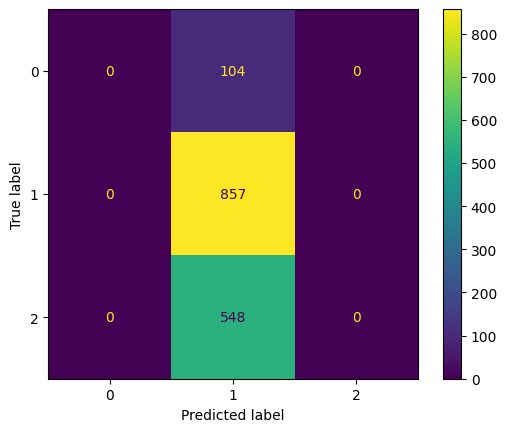

In [28]:
plot_confusion_matrix(dum, X_val_vec, y_val)

### First Model -- Multinomial Naive Bayes with count vectorizer

In [29]:
baseline_model = MultinomialNB()

In [30]:
baseline_model.fit(X_t_vec, y_t)

MultinomialNB()

In [31]:
y_hat = baseline_model.predict(X_val_vec)

In [32]:
# from sklearn.model_selection import cross_val_score

In [33]:
# baseline_cv = cross_val_score(baseline_model, X_t_vec, y_t)

In [34]:
# baseline_cv.mean()

In [35]:
y_t.value_counts(normalize=True)

1    0.573607
2    0.355659
0    0.070734
Name: target, dtype: float64

If we were to predict the majority class of 1 every time we would have an accuracy of 56%. Our baseline model has an accuracy score of 67%, which is already better than just pure guessing. 

In [36]:
accuracy_score(y_val, y_hat)

0.6315440689198144

In [37]:
precision_score(y_val, y_hat, average='weighted')

0.6188859657045401

In [38]:
cm = confusion_matrix(y_val, y_hat)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


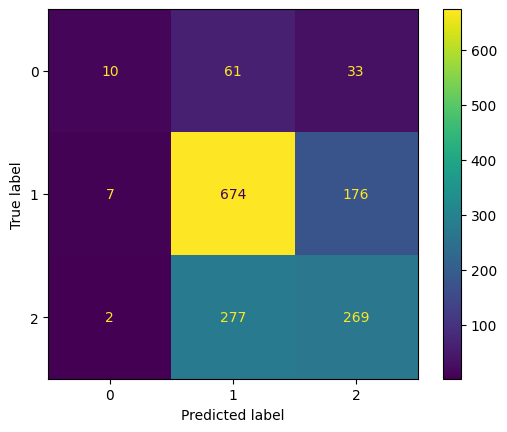

In [39]:
plot_confusion_matrix(baseline_model, X_val_vec, y_val)

In [91]:
from yellowbrick.classifier import ROCAUC

Because sklearn ROCAUC curve only supports binary classifiers we used a library from [Yellowbrick](https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html?highlight=roc#multi-class-rocauc-curves)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


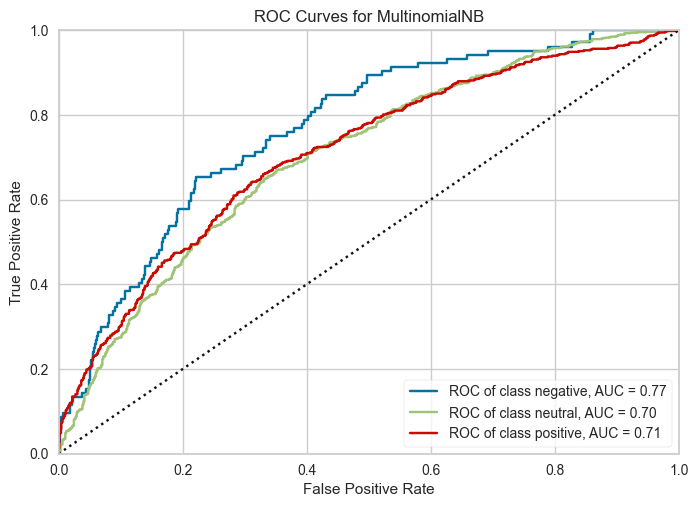

<AxesSubplot:title={'center':'ROC Curves for MultinomialNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [101]:
visualizer = ROCAUC(baseline_model, 
                    classes = ['negative', 'neutral', 'positive'], 
                   micro=False, macro=False)

visualizer.fit(X_t_vec, y_t)
visualizer.score( X_val_vec, y_val)
visualizer.show()

### Second Model -- MNB with TFIDF vectorizer

In [40]:
tfidf = TfidfVectorizer()
X_t_vec2 = tfidf.fit_transform(X_t)

In [41]:
X_val_vec2 = tfidf.transform(X_val)

In [42]:
mnb2 = MultinomialNB()
mnb2.fit(X_t_vec2, y_t)
y_hat2 = mnb2.predict(X_val_vec2)

In [43]:
accuracy_score(y_val, y_hat2)

0.6222664015904572

In [44]:
precision_score(y_val, y_hat2, average='weighted')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6056944537148465

Score decreased with TFIDF vectorizer, will continue to test with both types of vectors with RF model to compare scores.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


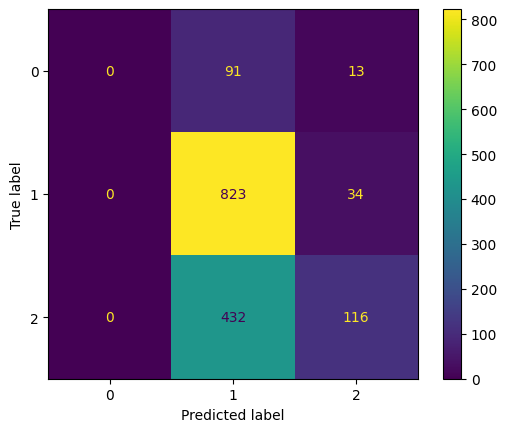

In [45]:
plot_confusion_matrix(mnb2, X_val_vec2, y_val)

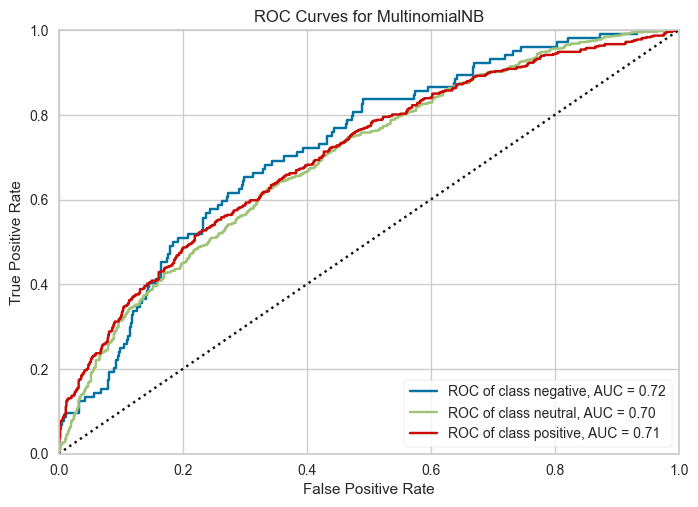

<AxesSubplot:title={'center':'ROC Curves for MultinomialNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [102]:
visualizer = ROCAUC(mnb2, 
                    classes = ['negative', 'neutral', 'positive'],
                   micro=False, macro=False)

visualizer.fit(X_t_vec2, y_t)
visualizer.score( X_val_vec2, y_val)
visualizer.show()

### Third Model -- Random Forests with Count vectorizer

In [46]:
cv2 = CountVectorizer()

In [47]:
X_t_vec3 = cv2.fit_transform(X_t)

In [48]:
X_val_vec3 = cv2.transform(X_val)

In [49]:
rf = RandomForestClassifier(random_state=42, 
                            n_estimators=1000, 
                            max_features= 'sqrt')

In [50]:
rf.fit(X_t_vec3, y_t)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [51]:
y_hat3 = rf.predict(X_val_vec3)
precision_score(y_val, y_hat3, average='weighted')

0.6370888475729599

In [52]:
accuracy_score(y_val, y_hat3)

0.6408217362491716

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


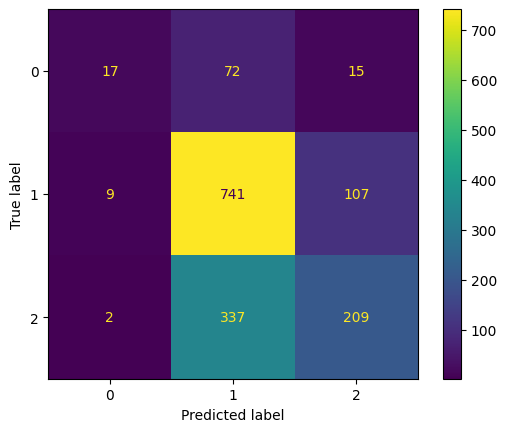

In [53]:
plot_confusion_matrix(rf, X_val_vec3, y_val)

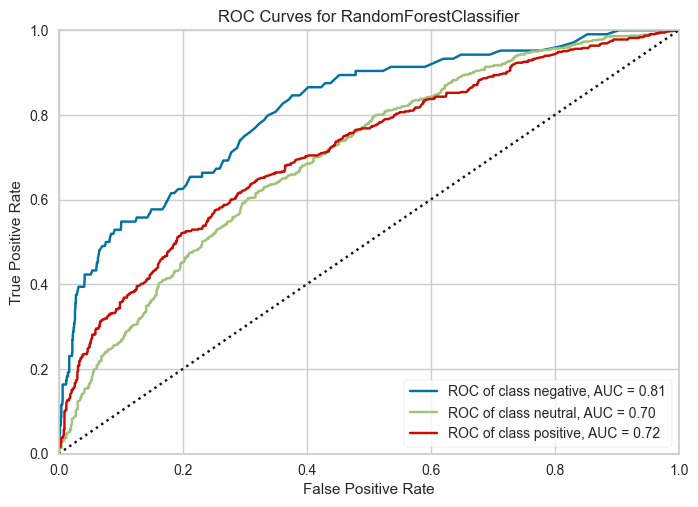

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [103]:
visualizer = ROCAUC(rf, 
                    classes = ['negative', 'neutral', 'positive'],
                   micro=False, macro=False)

visualizer.fit(X_t_vec3, y_t)
visualizer.score( X_val_vec3, y_val)
visualizer.show()

### Fourth Model with Random Forests and TFIDF

In [54]:
tfidf2 = TfidfVectorizer()
X_t_vec4 = tfidf2.fit_transform(X_t)

In [55]:
X_val_vec4 = tfidf2.transform(X_val)

In [56]:
rf2 = RandomForestClassifier(random_state=42, 
                            n_estimators=1000, 
                            max_features= 'sqrt')

In [57]:
rf2.fit(X_t_vec4, y_t)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [58]:
y_hat4 = rf2.predict(X_val_vec4)
precision_score(y_val, y_hat4, average='weighted')

0.6290685653718763

In [59]:
accuracy_score(y_val, y_hat4)

0.634857521537442

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


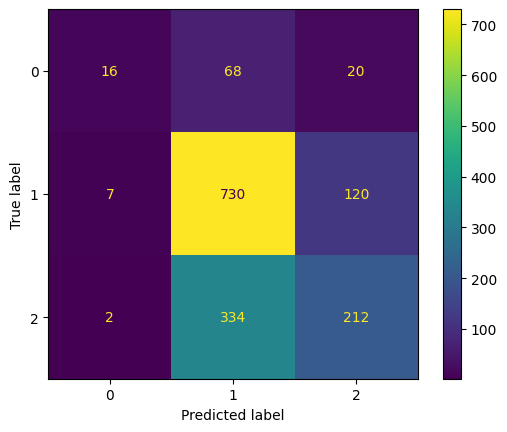

In [60]:
plot_confusion_matrix(rf2, X_val_vec4, y_val)

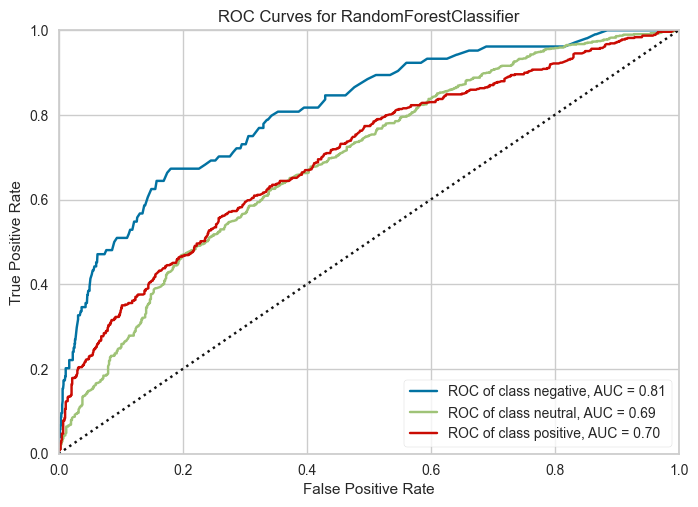

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [104]:
visualizer = ROCAUC(rf2, 
                    classes = ['negative', 'neutral', 'positive'],
                   micro=False, macro=False)

visualizer.fit(X_t_vec4, y_t)
visualizer.score( X_val_vec4, y_val)
visualizer.show()

In [121]:
df_tfidf = pd.DataFrame(X_val_vec4.toarray(), columns=tfidf2.get_feature_names())
df_tfidf

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,______,_______quot,_and_,_really_,_ыќ,aapl,aaron,aarpbulletin,ab,abacus,...,ычsxsw,ыј,ыќ,ыќltlt,ыў,єј,єґ,њпўћпаљь_ѓкѓоѓтѓјѓбввѓ_ѓјѓџв_ывrt,ќ_,џўбѕ_оѕрўќ__љ__ќ_фќипќ_гњцэќзьљјј
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
df_tfidf.iloc[1500].sort_values(ascending=False)[:10]

experiential    0.464075
ltlt            0.464075
popupstore      0.405635
brilliant       0.356894
via             0.213318
by              0.210530
popup           0.194107
mention         0.178335
austin          0.175034
store           0.148235
Name: 1500, dtype: float64

### Baseline Model Evalution
Of our 4 baseline models, the best performing was model 3 -- Count Vectorizer with Random Forests. It had an overall precision of 63.7% and a accuracy score of 64.1%. We are choosing this model to run without stopwords.

### Model Without Stop Words
### CV - RF w/o stop words

In [61]:
sw = stopwords.words('english')

In [62]:
cv3 = CountVectorizer(stop_words=sw)

In [63]:
X_t_vec_sw = cv3.fit_transform(X_t)
X_val_vec_sw = cv3.transform(X_val)

In [64]:
rf_sw = RandomForestClassifier(random_state=42, 
                            n_estimators=1000, 
                            max_features= 'sqrt')

In [65]:
rf_sw.fit(X_t_vec_sw, y_t)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [66]:
y_hat5 = rf_sw.predict(X_val_vec_sw )
precision_score(y_val, y_hat5, average='weighted')

0.6397194564358487

In [67]:
accuracy_score(y_val, y_hat5)

0.6447978793903247

Removing stop word only slightly increased the accuracy and precision. 

In [68]:
### Grid Searching for best parameters

In [ ]:
rf = RandomForestClassifier()

params = {}
params['max_features'] = ['sqrt', 'log2']
params['n_estimators'] = [10, 100, 1000]

In [ ]:
# grid_search = GridSearchCV(
#     rf, 
#     param_grid=params, 
#     scoring='accuracy',
#     n_jobs=-1,
#     verbose=10
# )

# grid_result = grid_search.fit(X_t_vec, y_t)

# # summarization
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']

# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

### Changing min & max df

**min_df** is used for removing terms that appear too infrequently. For example:

**min_df** = 0.01 means "ignore terms that appear in less than 1% of the documents".
**min_df** = 5 means "ignore terms that appear in less than 5 documents".
The default **min_df** is 1, which means "ignore terms that appear in less than 1 document". Thus, the default setting does not ignore any terms.

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:

**max_df** = 0.50 means "ignore terms that appear in more than 50% of the documents".
**max_df** = 25 means "ignore terms that appear in more than 25 documents".
The default **max_df** is 1.0, which means "ignore terms that appear in more than 100% of the documents". Thus, the default setting does not ignore any terms.

In [69]:
cv_sw2 =CountVectorizer(stop_words= sw, max_df=0.95)

In [70]:
X_t_vec6 = cv_sw2.fit_transform(X_t)

In [71]:
X_val_vec6 = cv_sw2.transform(X_val)

In [72]:
rf3 = RandomForestClassifier(random_state=42, 
                            n_estimators=1000, 
                            max_features= 'sqrt')

In [73]:
rf3.fit(X_t_vec6, y_t)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [74]:
y_hat6 = rf3.predict(X_val_vec6)


In [75]:
precision_score(y_val, y_hat6, average='weighted')

0.6446073285198597

In [76]:
accuracy_score(y_val, y_hat6)

0.6487740225314778

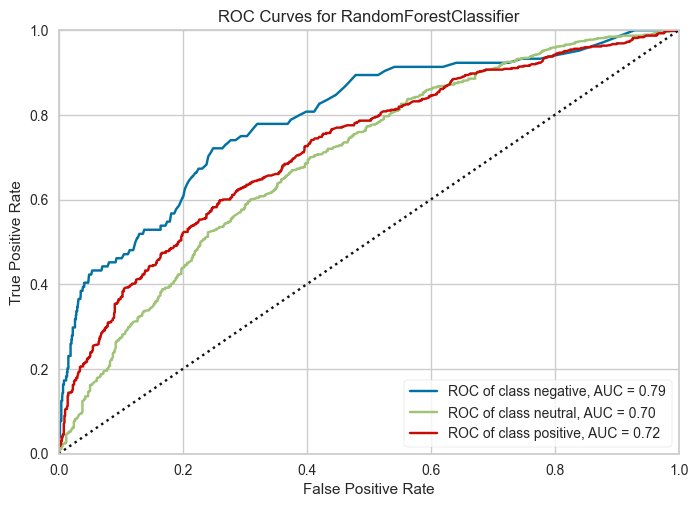

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [105]:
visualizer = ROCAUC(rf3, 
                    classes = ['negative', 'neutral', 'positive'],
                   micro=False, macro=False)

visualizer.fit(X_t_vec6, y_t)
visualizer.score( X_val_vec6, y_val)
visualizer.show()

Changing the min_df essentially had no effect on the accuracy or precision of the model. But changing max_df from the default of 1.0 to 0.95 increased the model's precision to 64.6% and the accuracy score to 64.9%.

### Model Evaluation on Test Set

In [77]:
final_cv_sw = CountVectorizer(stop_words=sw, max_df=0.95)
X_vec_train_final = final_cv_sw.fit_transform(X_train)
X_vec_test_final = final_cv_sw.transform(X_test)

In [78]:
final_model = RandomForestClassifier(random_state=42, 
                            n_estimators=1000, 
                            max_features= 'sqrt')

In [79]:
final_model.fit(X_vec_train_final, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [80]:
#training set score
final_model.score(X_vec_train_final, y_train)

0.9955246146195923

In [81]:
y_hat_final = final_model.predict(X_vec_test_final)

In [82]:
# test set score
final_model.score(X_vec_test_final, y_test)

0.6605367793240556

In [83]:
precision_score(y_test, y_hat_final, average='weighted')

0.6678474958454174

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


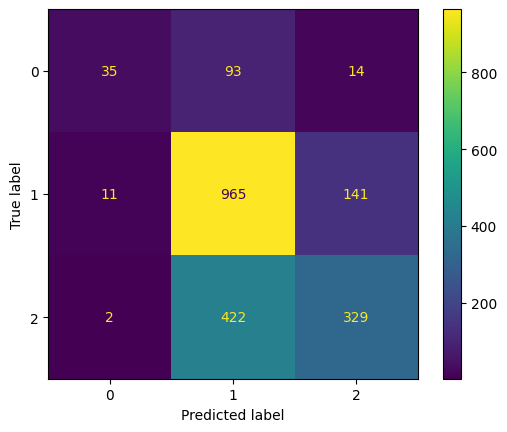

In [84]:
plot_confusion_matrix(final_model, X_vec_test_final, y_test)

The model seems to be labeling positive tweets as neutral. This may be from duplicate tweets that have different sentiments between the train and test sets. We believe that the model may be overtrained on neutral tweets. 

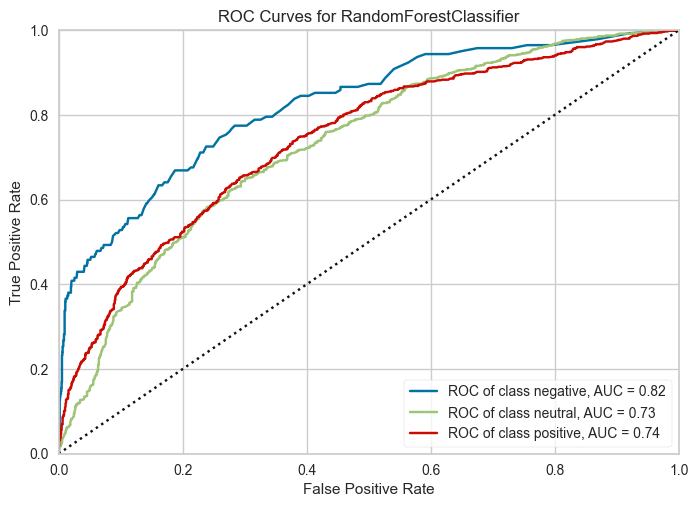

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [107]:
visualizer = ROCAUC(final_model, 
                    classes = ['negative', 'neutral', 'positive'],
                   micro=False, macro=False)

visualizer.fit(X_vec_train_final, y_train)
visualizer.score( X_vec_test_final, y_test)
visualizer.show()

***

In [ ]:
# pip install wordcloud

# from wordcloud import WordCloud

# import matplotlib as plt

# def generate_wordcloud(corpus, collocations = False, background_color ='black',
#                       colormap='Greens', display = True):
#     wordcloud = WordCloud(collocations=collocations, background_color=background_color,
#                          colormap=colormap, width=500, height=300)
#     wordcloud.generate(','.join(corpus))
    
#     if display:
#         plt.figure(figsize= (12,15), facecolor=None)
#         plt.imshow(wordcloud)
#         plt.axis('off');
#     return wordcloud